# SingleCell Data Analysis on the CPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

sc._settings.ScanpyConfig.n_jobs = 60

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. 

In [2]:
data_load_start = time.time()

In [3]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 2.58 s, sys: 92.8 ms, total: 2.68 s
Wall time: 2.67 s


In [4]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 2.6813697814941406


## Preprocessing

In [5]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

Some genes will now have zero expression in all cells. We filter out such genes.

In [6]:
%%time
adata.var['MT'] = adata.var_names.str.startswith('MT-') 

CPU times: user 7.58 ms, sys: 0 ns, total: 7.58 ms
Wall time: 7.34 ms


In [7]:
%%time
adata.var['RIBO'] = adata.var_names.str.startswith('RPS') 


CPU times: user 5.39 ms, sys: 483 µs, total: 5.88 ms
Wall time: 5.73 ms


In [8]:
%%time
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT','RIBO'], percent_top=None, log1p=False, inplace=True)

CPU times: user 1.62 s, sys: 90.1 ms, total: 1.71 s
Wall time: 1.71 s


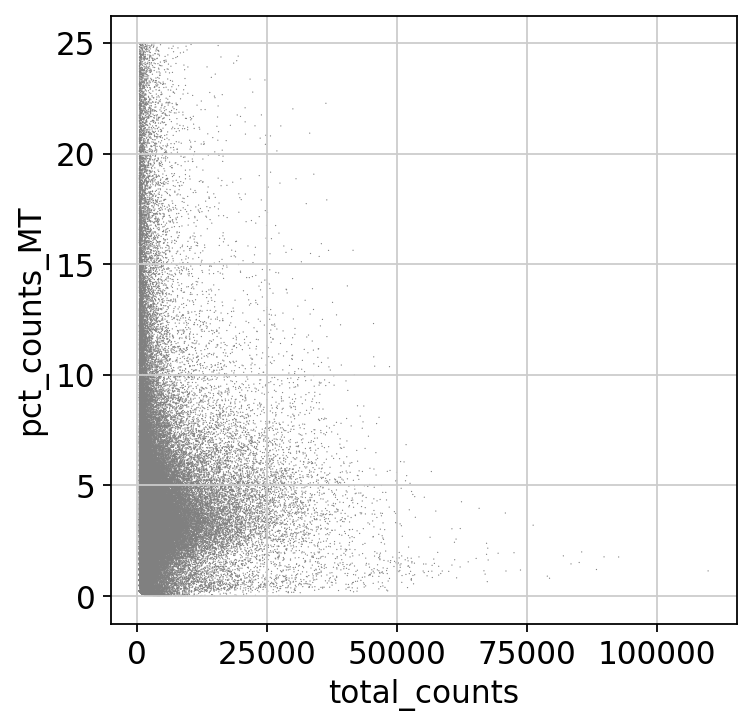

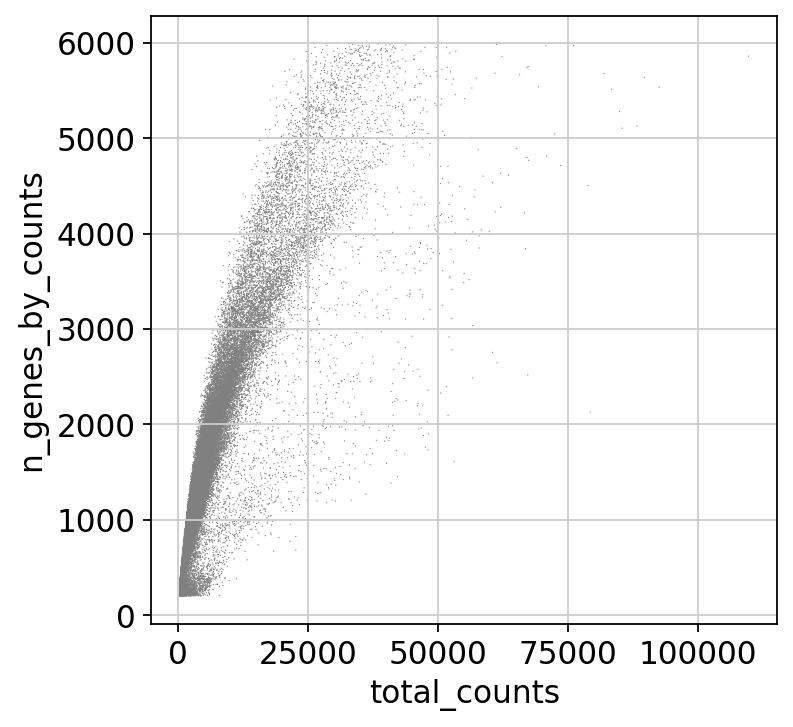

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

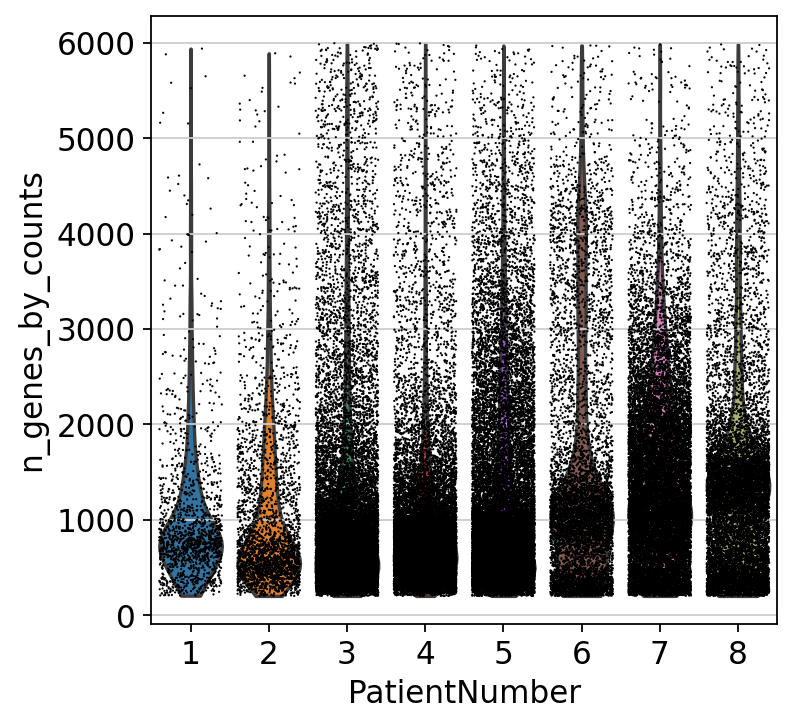

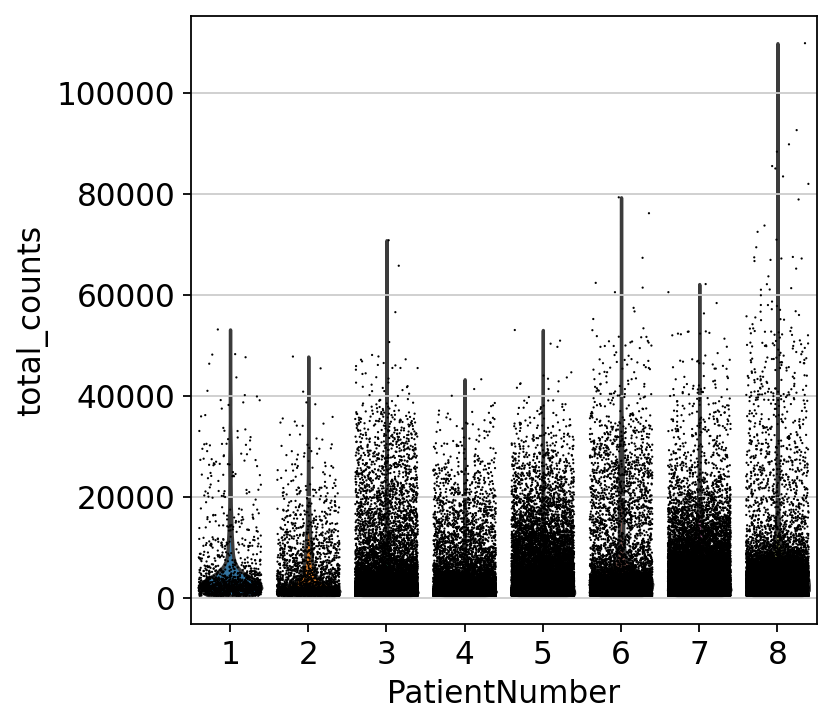

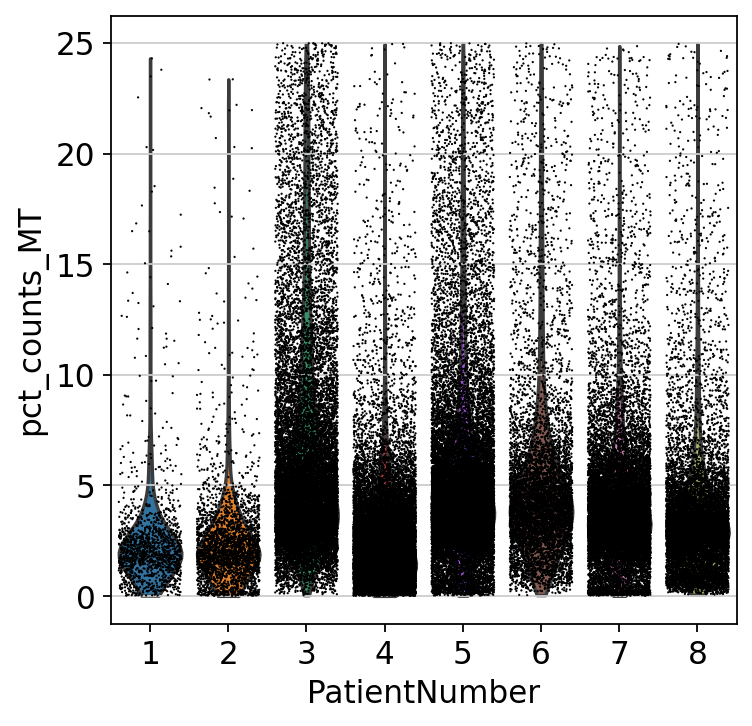

In [10]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'total_counts',jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4, groupby="PatientNumber")


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

The size of our count matrix is now reduced.

In [11]:
%%time
adata = adata[adata.obs.n_genes_by_counts < 5000, :].copy()
adata = adata[adata.obs.pct_counts_MT < 20, :].copy()

CPU times: user 204 ms, sys: 227 ms, total: 431 ms
Wall time: 430 ms


In [12]:
%%time
sc.pp.filter_genes(adata, min_cells=3)

CPU times: user 654 ms, sys: 239 ms, total: 893 ms
Wall time: 892 ms


Some genes will now have zero expression in all cells. We filter out such genes.

In [13]:
adata.shape

(91180, 25365)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [14]:
%%time
sc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 282 ms, sys: 39.9 ms, total: 322 ms
Wall time: 321 ms


Next, we log transform the count matrix.

In [15]:
%%time
sc.pp.log1p(adata)

CPU times: user 1.04 s, sys: 1.85 ms, total: 1.04 s
Wall time: 1.04 s


### Select Most Variable Genes

We will now select the most variable genes in the dataset.

In [16]:
%%time
sc.pp.highly_variable_genes(adata,flavor = "cell_ranger",n_top_genes=5000)

CPU times: user 632 ms, sys: 27.8 ms, total: 660 ms
Wall time: 659 ms


Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use

In [17]:
%%time
adata.raw = adata

CPU times: user 41.3 ms, sys: 54.7 ms, total: 96.1 ms
Wall time: 94.9 ms


Restrict adata to only the highly variable genes

In [18]:
%%time
adata = adata[:, adata.var.highly_variable].copy()

CPU times: user 368 ms, sys: 151 ms, total: 519 ms
Wall time: 518 ms


In [19]:
adata.shape

(91180, 5000)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. 

In [20]:
%%time
sc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 8.18 s, sys: 12.7 s, total: 20.9 s
Wall time: 20.9 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [21]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.54 s, sys: 151 ms, total: 1.69 s
Wall time: 1.69 s


We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [22]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 30.73722767829895


## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. 

In [23]:
%%time
sc.tl.pca(adata, n_comps = 100)

CPU times: user 1h 18min 26s, sys: 12min 50s, total: 1h 31min 17s
Wall time: 47.1 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

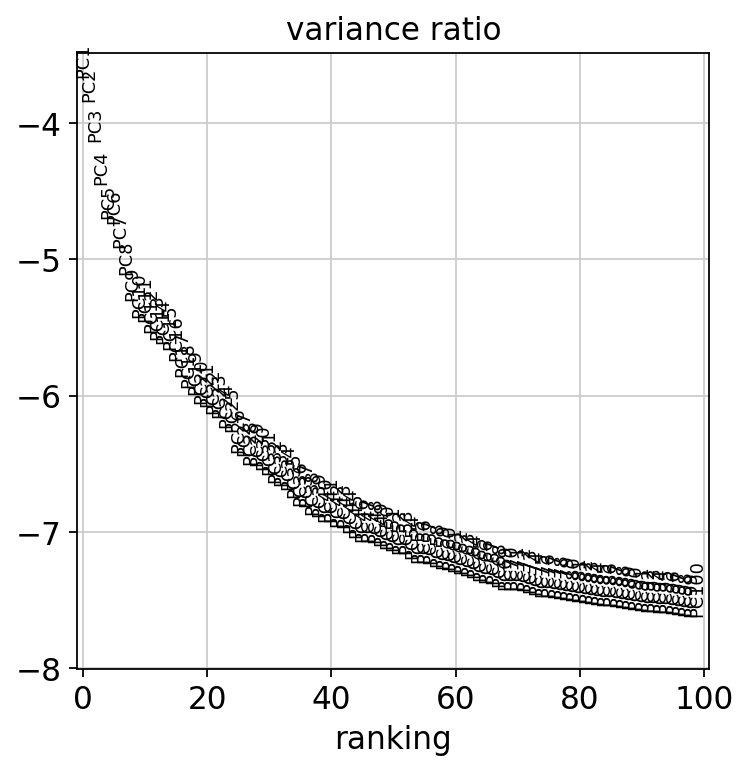

In [24]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph and UMAP

In [25]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 1min 28s, sys: 3min 57s, total: 5min 25s
Wall time: 22.1 s


In [26]:
%%time
sc.tl.umap(adata)

CPU times: user 3min 42s, sys: 7min 8s, total: 10min 50s
Wall time: 35.8 s


### Clustering
We cluster the cells with the Leiden and Louvain algorithm

In [27]:
%%time
sc.tl.louvain(adata)

CPU times: user 17.1 s, sys: 138 ms, total: 17.2 s
Wall time: 17.2 s


In [28]:
%%time
sc.tl.leiden(adata)

CPU times: user 22.7 s, sys: 111 ms, total: 22.8 s
Wall time: 22.8 s


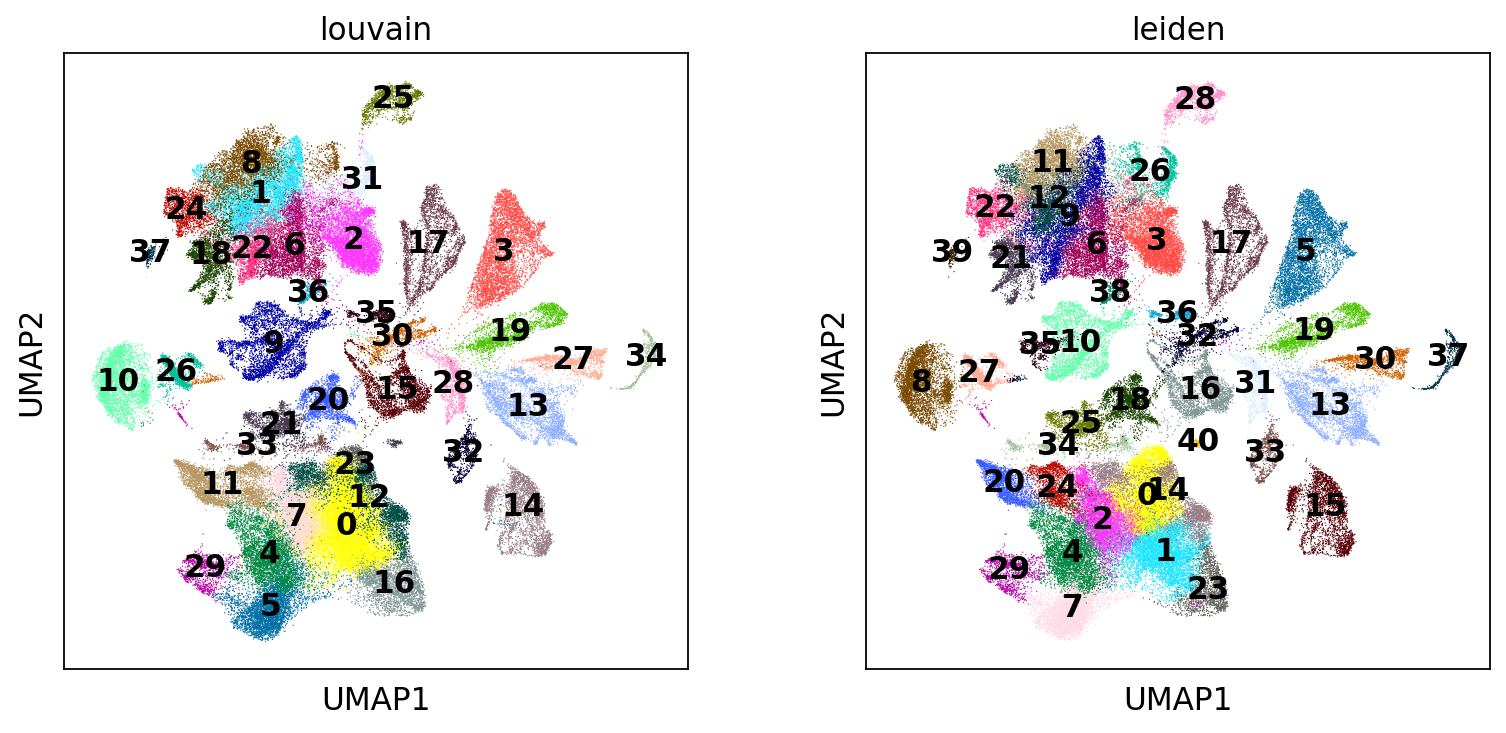

CPU times: user 802 ms, sys: 156 ms, total: 958 ms
Wall time: 764 ms


In [29]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

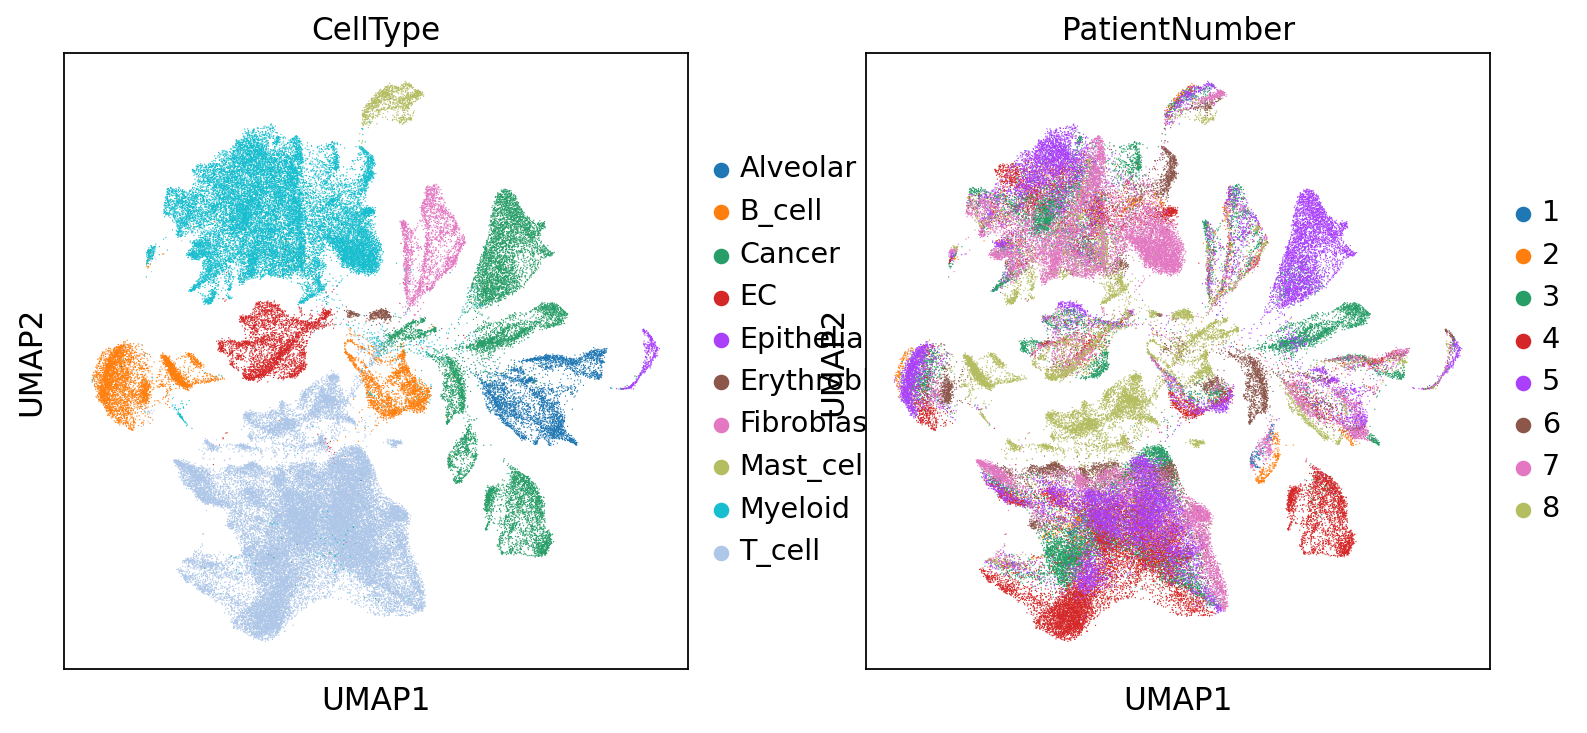

In [30]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

### TSNE + K-means
You might want to skip this step. Calucating a TSNE for 90000 cells takes really long 

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

In [32]:
%%time
sc.tl.tsne(adata, n_pcs = 40)

/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/scanpy/tools/_tsne.py:113: UserWarning: In previous versions of scanpy, calling tsne with n_jobs > 1 would use MulticoreTSNE. Now this uses the scikit-learn version of TSNE by default. If you'd like the old behaviour (which is deprecated), pass 'use_fast_tsne=True'. Note, MulticoreTSNE is not actually faster anymore.
  warnings.warn(
/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


CPU times: user 2h 27min 15s, sys: 2h 41min 51s, total: 5h 9min 6s
Wall time: 6min 11s


/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'kmeans' as categorical


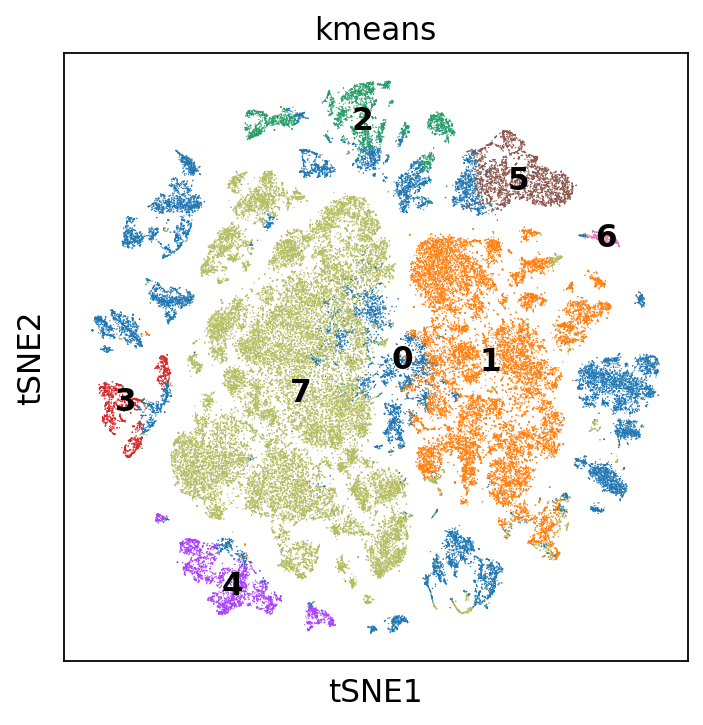

In [33]:
sc.pl.tsne(adata,color=["kmeans"], legend_loc='on data')

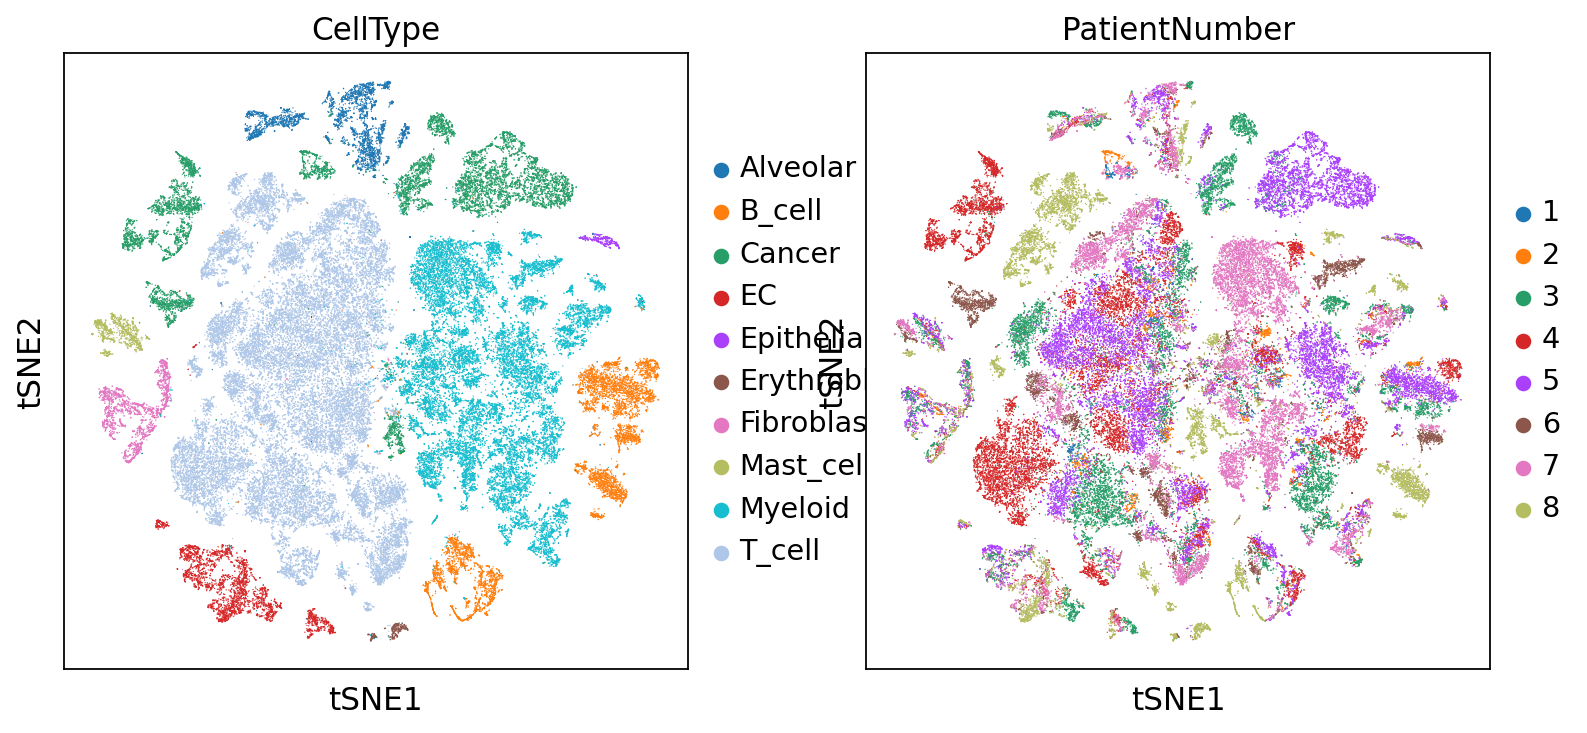

CPU times: user 1.07 s, sys: 0 ns, total: 1.07 s
Wall time: 880 ms


In [34]:
%%time
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

In [35]:
%%time
sc.tl.rank_genes_groups(adata, 'CellType', method='logreg', use_raw=False)

CPU times: user 1h 3min 11s, sys: 38min 54s, total: 1h 42min 6s
Wall time: 53.9 s


/home/sdicks-local/conda/rapids-22.06/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


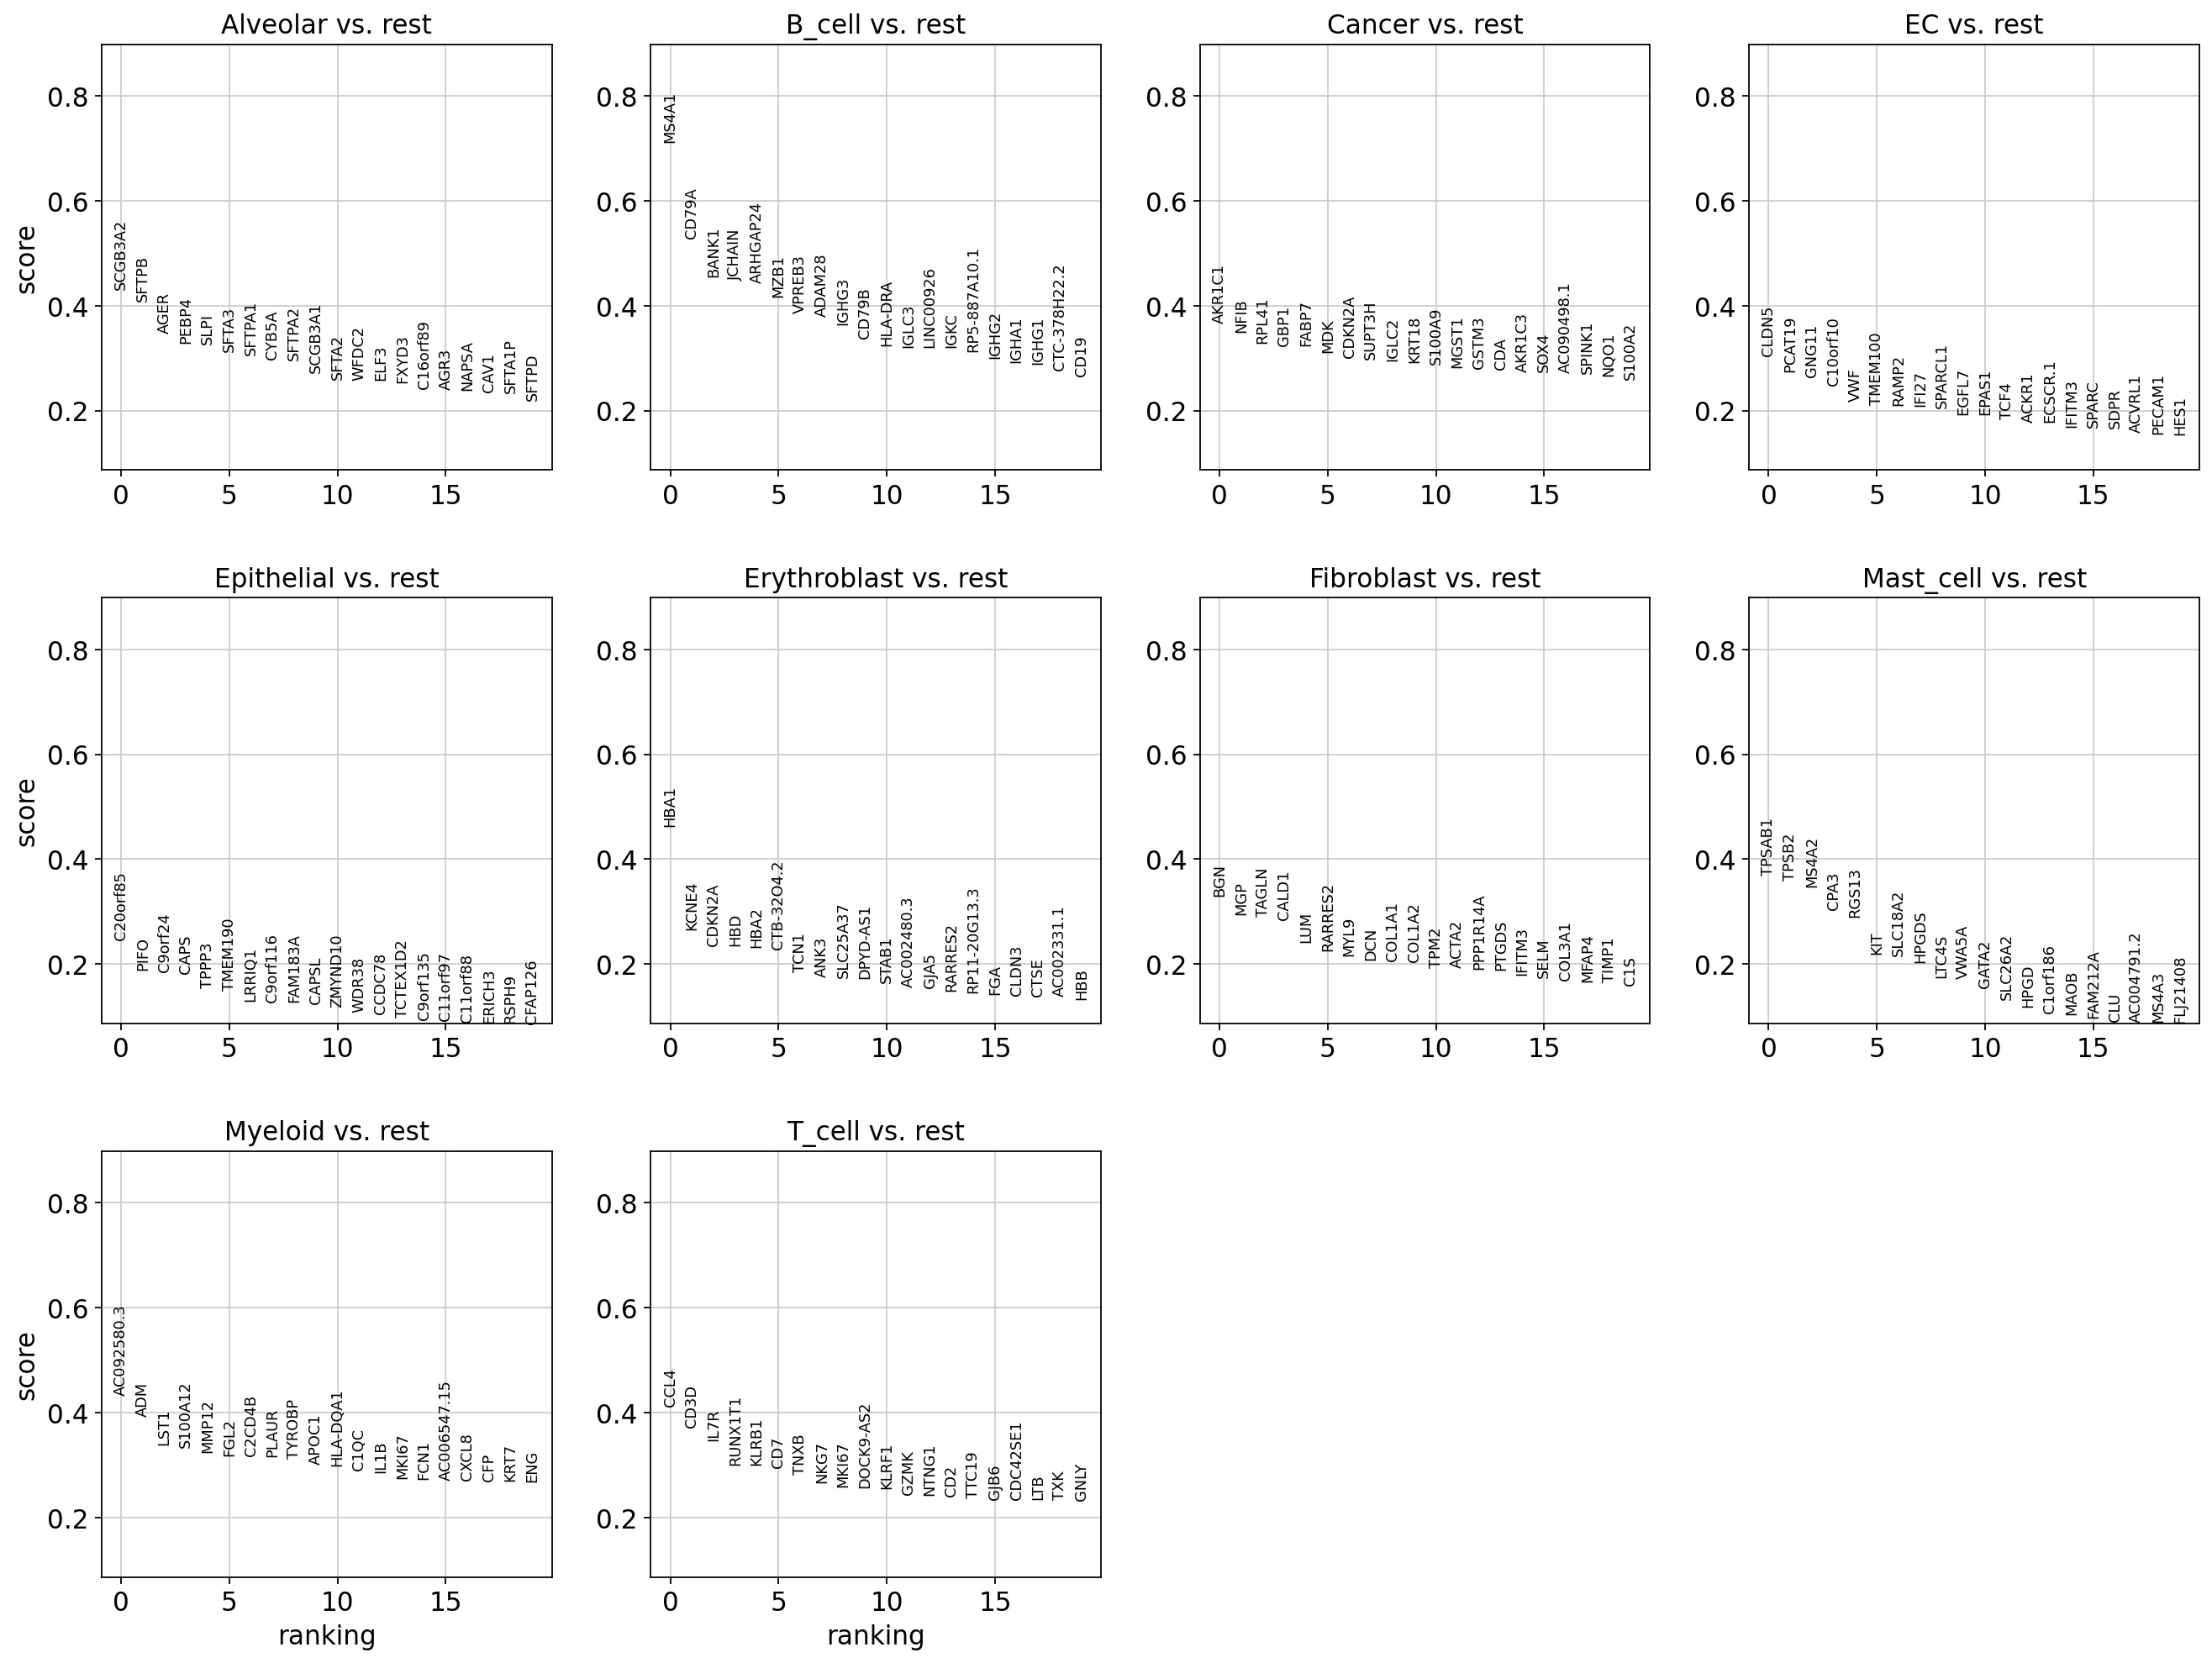

CPU times: user 2.34 s, sys: 5.67 s, total: 8.01 s
Wall time: 995 ms


In [36]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [37]:
post_time = time.time()

In [38]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 591.3913240432739


## Diffusion Maps

We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [39]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:]

We can repeat the dimension reduction, clustering and visulatization.

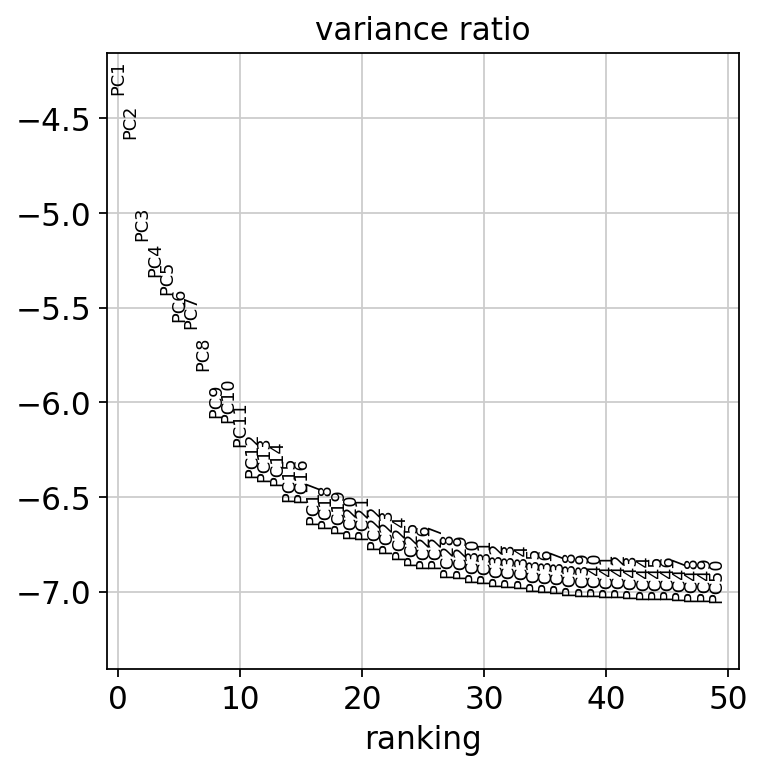

CPU times: user 35min 26s, sys: 4min 55s, total: 40min 22s
Wall time: 22.2 s


In [40]:
%%time
sc.pp.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [41]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
sc.tl.umap(tdata)
sc.tl.louvain(tdata)

CPU times: user 1min 12s, sys: 2min 7s, total: 3min 20s
Wall time: 21.9 s


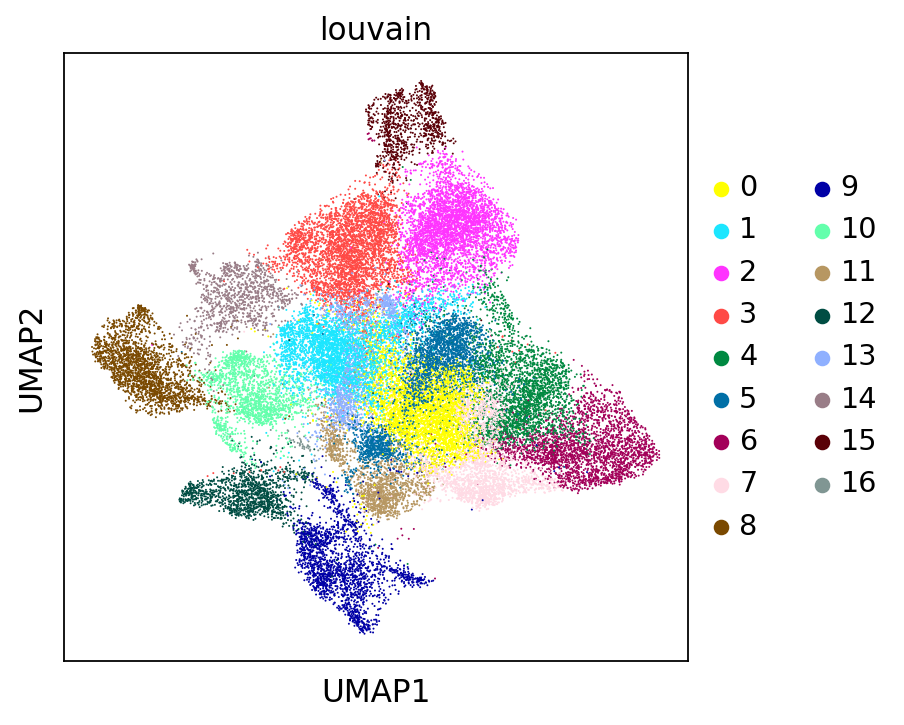

In [42]:
sc.pl.umap(tdata, color=["louvain"])

In [43]:
%%time
sc.tl.diffmap(tdata)

CPU times: user 37 s, sys: 1min 35s, total: 2min 12s
Wall time: 1.38 s


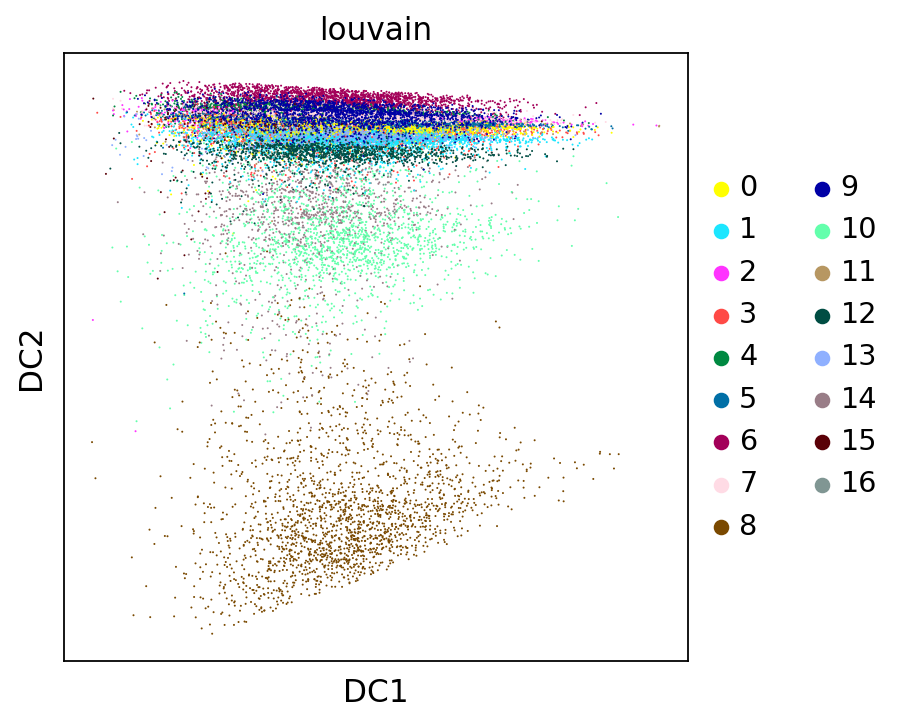

In [44]:
sc.pl.diffmap(tdata, color='louvain')

In [45]:
%%time
sc.tl.draw_graph(tdata)

CPU times: user 4min 12s, sys: 724 ms, total: 4min 12s
Wall time: 4min 12s


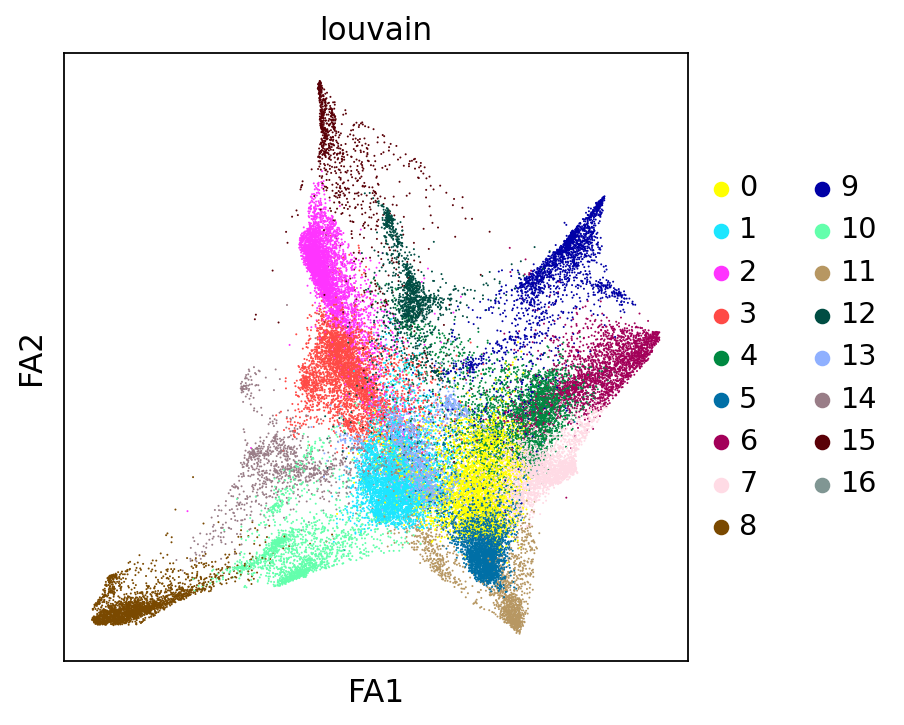

In [46]:
sc.pl.draw_graph(tdata, color='louvain')

In [47]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Preprocessing time: 921.7527165412903
